## Loading packages and setting up Jupyter notebook

In [1]:
import pdb 
import glob

import numpy as np
import pandas as pd
import scipy as sp
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline 
import seaborn as sns
 
import missingno  # for visualizing missing data

In [2]:
# Load extensions
%load_ext memory_profiler

In [3]:
# Set up pandas table display
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Set seaborn options
sns.set()
# sns.set_context("notebook") 

In [4]:
#mpl.rcParams['figure.figsize'] = (10.0, 10.0) 

# Data 
A subset of the data is publicly available on Lending Club's website, but in order to access all the data I had to create an account. This data set is very comprehensive, it spans about 10 years (from 2007 – shortly after the firm's founding – to the present) and contains roughly 1.8 million observations for 150 variables.

## Inspecting data files

The data come in separate csv files that contain from a quarter up to multiple years of records. Let's inspect the individual files in the shell before importing them into pandas. 

In [5]:
# Print-out not shown because it is very long
# !head -2 data_raw/*.csv

This reveals that the first line contains comments and should thus be discarded when importing the data. The column names start in the second line.

## Importing data

In [6]:
# Get all the csv files in the data directory
files = glob.glob('data_raw/*.csv')

# Read those files into pandas
df_list = [pd.read_csv(file, header=1, low_memory=False) for file in files]

# Concatenate them into one DataFrame
all_data = pd.concat(df_list, ignore_index=True) 

# Get rid of the individual DataFrames
del df_list 

# Exploratory Data Analysis
Let's start with the dimension of our data set.

In [7]:
all_data.shape

(1873317, 151)

This reveals that we have about 1.8 million observations and 151 columns. Thus, let's start by getting rid of irrelevant observations and columns. We will then take a look at missing values in order to decide whether to impute them or to drop the whole column. 

Subsequently, we will explore how important loan outcomes have changed over time, and if we should discard data from the earliest years if it is too different from later observations. Once this is completed, we have arrived at the final set of observations and variables for the analysis, and we can start to explore distributions of individual variables as well as continue to explore relationship amongst other other variables.

## Dropping Duplicats
Now let's look if there are any duplicats in the data:

In [8]:
all_data.duplicated().sum()

0

No duplicats were found, so we don't have to take any action.

## Dropping irrelevant observations
To zoom in on only the relevant observation, let us take a look at the variable of interest, loan_status. This will allow us to filter out cases where the outcome is ambiguous:

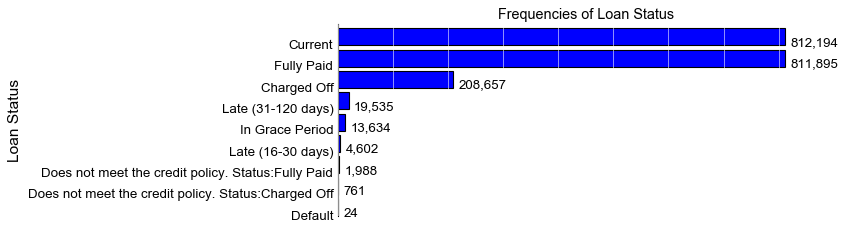

In [9]:
# sns.reset_defaults()
with plt.style.context('classic'): # Discard Seaborn defaults

    counts = all_data.loan_status.value_counts(ascending=True)  
    ind = np.arange(len(counts))  # y-axis

    fig, ax = plt.subplots(figsize=(8, 3))
    ax.barh(y=ind, width=counts)

    ax.set_title("Frequencies of Loan Status", fontsize=13)
    # ax.set_xlabel("Frequencies of Loan Status", fontsize=14)
    ax.set_ylabel("Loan Status", fontsize=14)

    ax.set_yticks(ind)  # Get rid of extra ticks on top and bottom
    ax.set_yticklabels(counts.index)
    
    fig.patch.set_facecolor('w')  # Change background color to white  
    ax.grid(axis='x', color='white', linestyle='-')
    sns.despine(bottom=True)
    ax.tick_params(axis='both', which='both',length=0, labelsize=12, labelbottom=False)
    # ax.tick_params(axis='bottom', labelsize = 0)
    for y_position, count in zip(ind, counts):  # Add frequencies
        plt.annotate(format(count, ','), xy=(count+10000, y_position))

plt.show()

As the above figure shows, the vast majority of loans fall into 3 classes: Loans that are still current, Loans that were paid back completely, and loans that were written-off (i.e., loans are unlikely to be paid back). Only a small fraction of loans (in fact, only 24, too small to be visible in the graph) are categorized as defaults (meaning that we can be certain that they won't be paid back). Furthermore, there is a small number of loans for which the status variable contains the string "does not meet the credit policy" in addition to whether it is fully paid or charged-off. Unfortunately, there is no explanation anywhere what exactly this means. I will simply treat them as fully paid or charged off, and ignore the information about not meeting the credit policy, which seems to be a separate variable. However, I do not use it for prediction, because it is likely that this information only became available after the loan was issued (since presumably the loan would not have been issued if it had been known at the time that the borrower did not meet the credit policy).    

The main question we need to decide is what exactly we want to predict.  I opt for a dichotomous classification into "fully paid" versus "charged off" and "default". For simplicity sake, I will call those "good" loans and "bad" loans. Note that those two classes are imbalanced.

Loans which are late – from still being in the grace period to up to 120 days late – will be discarded, because their status is yet indeterminate.  We have enough observations already, and thus any gain in accuracy from these additional observations would most likely be more than offset by the increase in variance due to the greater measurement error, because we do not have enough information yet to accurately classify them.

For similar reasons, I will discard loans that are still current.

In [10]:
# Create target variable (good or bad loans)
all_data['good'] = np.NaN
all_data.loc[all_data.loan_status.str.contains('Fully Paid', na=False), 'good'] = 1  # "Good" loans
all_data.loc[(all_data.loan_status.str.contains('Charged Off', na=False)|(all_data.loan_status=='Default')), 'good'] = 0  # "Bad"

In [11]:
# Drop loans with indeterminate status
all_data = all_data.loc[all_data.good.notnull(),:]

## Indexing and Sorting Data
A natural index for the data is the "id" column. But first we need to make sure that it doesn't have any missing values.

In [12]:
all_data.id.isnull().sum()

0

It doesn't have any missing values, so we can use it. However, it would also be good to additionally index the data by the date that the loan was issued, so that we can sort and later potentially slice them by time. (Amongst other, this will come in handy later when looking at missing values, because we want to know if certain variables were simply not collected during certain time periods, or if they are missing for other reasons.)

Let's first take a look at how the issue data is formatted, so that we can more effectively parse it.

In [13]:
all_data.loc[:, 'issue_d'].head()

0    Dec-2011
1    Dec-2011
2    Dec-2011
3    Dec-2011
4    Dec-2011
Name: issue_d, dtype: object

Now we can set the issue date and loan ID as a hierarchical index, and then sort the data by date:

In [14]:
all_data['issue_d'] = pd.to_datetime(all_data.loc[:,'issue_d'], format='%b-%Y')

In [15]:
all_data = all_data.set_index(['issue_d', 'id']).sort_index()

## Dropping columns

Now that we have discarded irrelevant rows, let's discard irrelevant columns. Since we are starting with about 150 columns, this will make the EDA easier.

### Dropping constant or all-missing columns
Let's start by deleting columns which are either constant or for which all observations are missing:

In [16]:
# Find columns with 0 or 1 unique values
constant_or_missing = [col for col in all_data.columns if all_data.loc[:,col].value_counts().shape[0]<=1] 
print('Columns to be deleted:\n{}'.format(constant_or_missing))

# Delete those columns
all_data = all_data.drop(constant_or_missing, axis=1)

Columns to be deleted:
['member_id', 'pymnt_plan', 'policy_code', 'hardship_flag', 'hardship_type', 'deferral_term', 'hardship_length']


### Dropping columns with too many missing values
Now that we have discarded irrelevant rows and columns, let us take a closer look at the data. Firstly, let's see what percentage of each column is missing.

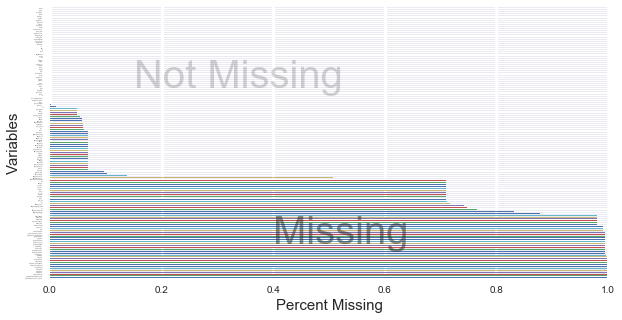

In [17]:
# Calculate the proportion of missing values for each variable
missing = (all_data.isnull().sum()/all_data.shape[0]).sort_values(ascending=False)

# Plot proportion of missing values for each variable 
missing.plot(kind="barh", figsize=(10, 5))
plt.xlim(0, 1)
plt.xlabel('Percent Missing', fontsize=15)
plt.ylabel('Variables', fontsize=15)
plt.tick_params(axis='y', length=0, labelsize = 0)
plt.grid(color="white", axis='x', linewidth=3)
plt.text(x=.15, y=100, s='Not Missing', fontsize=40, alpha=.2)
plt.text(x=.4, y=18, s='Missing', fontsize=40, alpha=.5)

plt.show()

Let us first focus on the big picture not worry about any individual variables. This reveals reveals an interesting pattern: Most variables cluster into groups with either no missing values (about a third of the variables), around 10% missing values (about a quarter), around 70% missing values (roughly 10% of variables), or almost all missing values (about a third of variables).

The fact that there are no variables that have between 15% and 65% missing values makes it easier for us to decide at what proportion of missing values we should draw a cut-off between dropping a variable and imputing missing values. I will choose 30% missing as the threshold, but any threshold between around 15% and around 65% would yield identical results.
    
This pattern could be due to the fact that, at certain points in time, additional batches of variables were starting to be collected. To look into this, let's aggregate the proportion of missing values by month and look for a time trend.

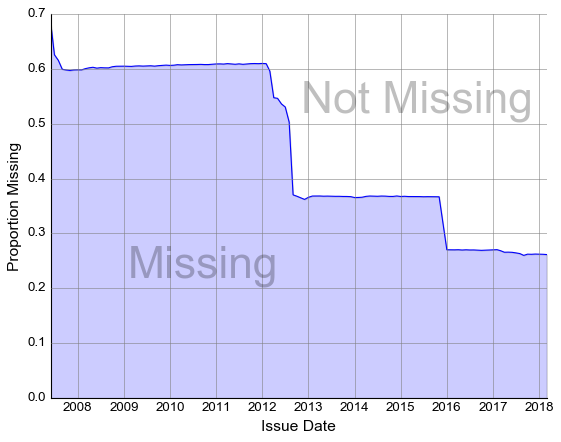

In [18]:
# Group-by month and calculate percentage of missing values
missing_by_year = all_data.groupby('issue_d').apply(lambda x: x.isnull().sum().sum()/(x.shape[0]*x.shape[1]))

with plt.style.context('classic'): # Discard Seaborn defaults
    fig, ax = plt.subplots()

    ax.plot(missing_by_year)
    ax.set(xlim=(min(missing_by_year.index), max(missing_by_year.index)), 
           ylim=(0, .7)) 
    ax.set_ylabel('Proportion Missing', fontsize=14)
    ax.set_xlabel('Issue Date', fontsize=14)
            
    ax.tick_params(length=0) 
    ax.fill_between(missing_by_year.index, 0, missing_by_year.values, alpha=.2)
    ax.grid(color='grey', linestyle='-')
    fig.patch.set_facecolor('w')       
    sns.despine()
    plt.text(x=missing_by_year.index[20], y=.22, s='Missing', fontsize=40, alpha=.25)
    plt.text(x=missing_by_year.index[65], y=.52, s='Not Missing', fontsize=40, alpha=.25)
    
plt.show()

It does indeed look like over time more and more variables were collected, and that these additional columns were for the most part added during three distinct time periods: In mid-2007 (only a few months after the first observations were collected), in 2012, and in late-2015.

To verify that it is in fact the same variables that are missing for a particular time period, we need to disaggregate these results by individual variables. If this shows that a particular variable has missing values that are distributed relatively evenly through time, we need to take a 2nd look at the meaning of the variable before dropping it to make sure that missingness does not simply denote that a variable is not applicable.  Obviously, if that was the case, there is no reason to drop it because it is not really missing – though we do have to find a way how to properly encode it. 
Conversely, if missingness for a particular variable mainly stems from the fact that it's observations were not collected during a substantial part of our sample period, we know that we can safely discard it. 

In the plot below, only variables that have at least one missing observation will be shown . Unfortunately, we still have too many columns to display the names of individual columns, so let's just focus on the big picture and plot smaller subsets later. Each column denotes a particular variable, and each row denotes an observation, ordered from earliest (top) to latest (bottom). Missing values are plotted as white, and non-missing values are plotted as black.  On the very right, there is a line graph that is supposed to show the number of non-missing values for each observation (ranging from 43 to 134), but due to the large number of observations graphed here, it is not very useful and can safely be ignored. 

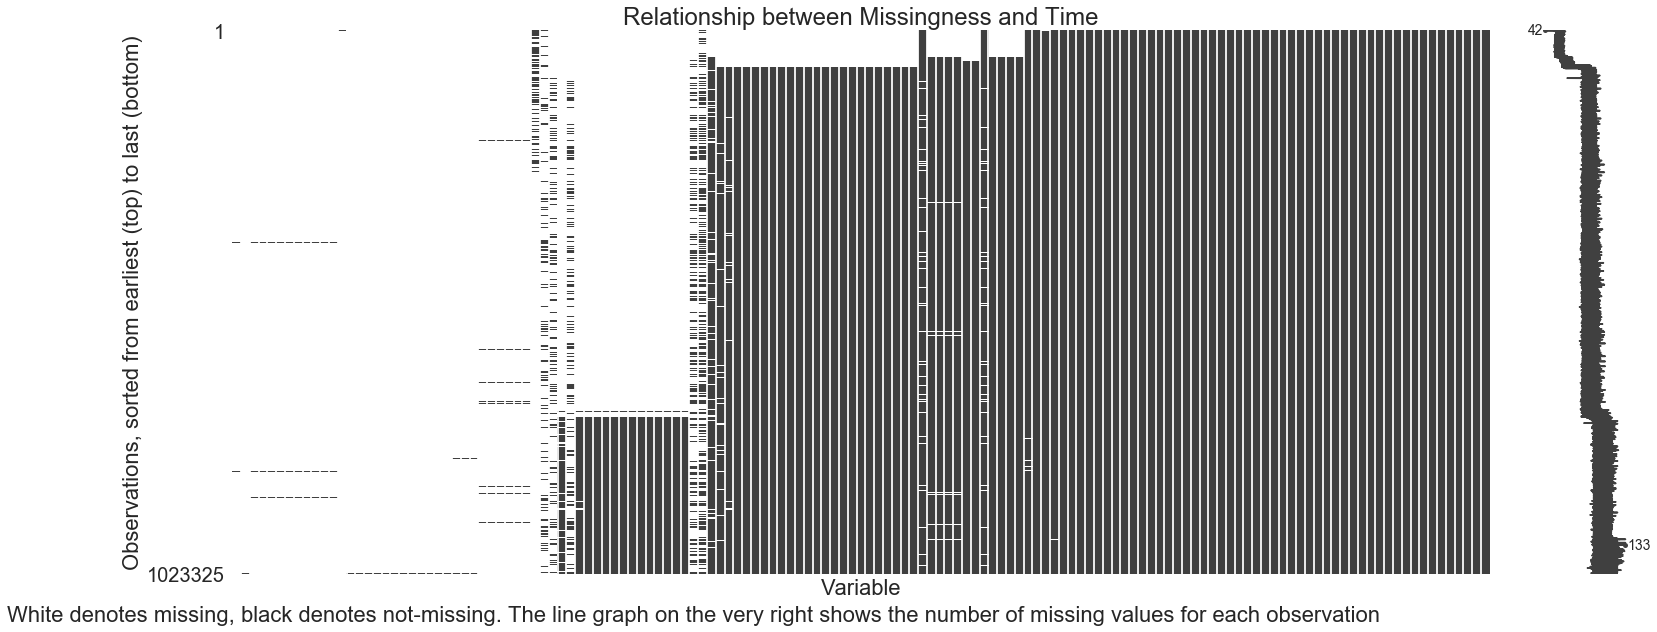

In [19]:
# Plot missing data
missingno.matrix(all_data.loc[:, missing.index])
plt.title('Relationship between Missingness and Time', \
          fontsize=24)
plt.ylabel('Observations, sorted from earliest (top) to last (bottom)', fontsize=22)
plt.xlabel('Variable', fontsize=22)
plt.figtext(x=0, y=.06, s="White denotes missing, black denotes not-missing. The line graph on the very right "
            "shows the number of missing values for each observation", fontsize=22)
plt.show();

This reveals that – with a few notable exceptions – most of the missingness is indeed caused by the fact that many variables were not collected over the whole sample period. At the same time, there are also a few variable with a substantial proportion of missing values that are distributed relatively evenly across time.

In order to be able to display the variable names, we need to split the variables up into several plots. Let's start with those variables that have the highest proportion of missingness: 

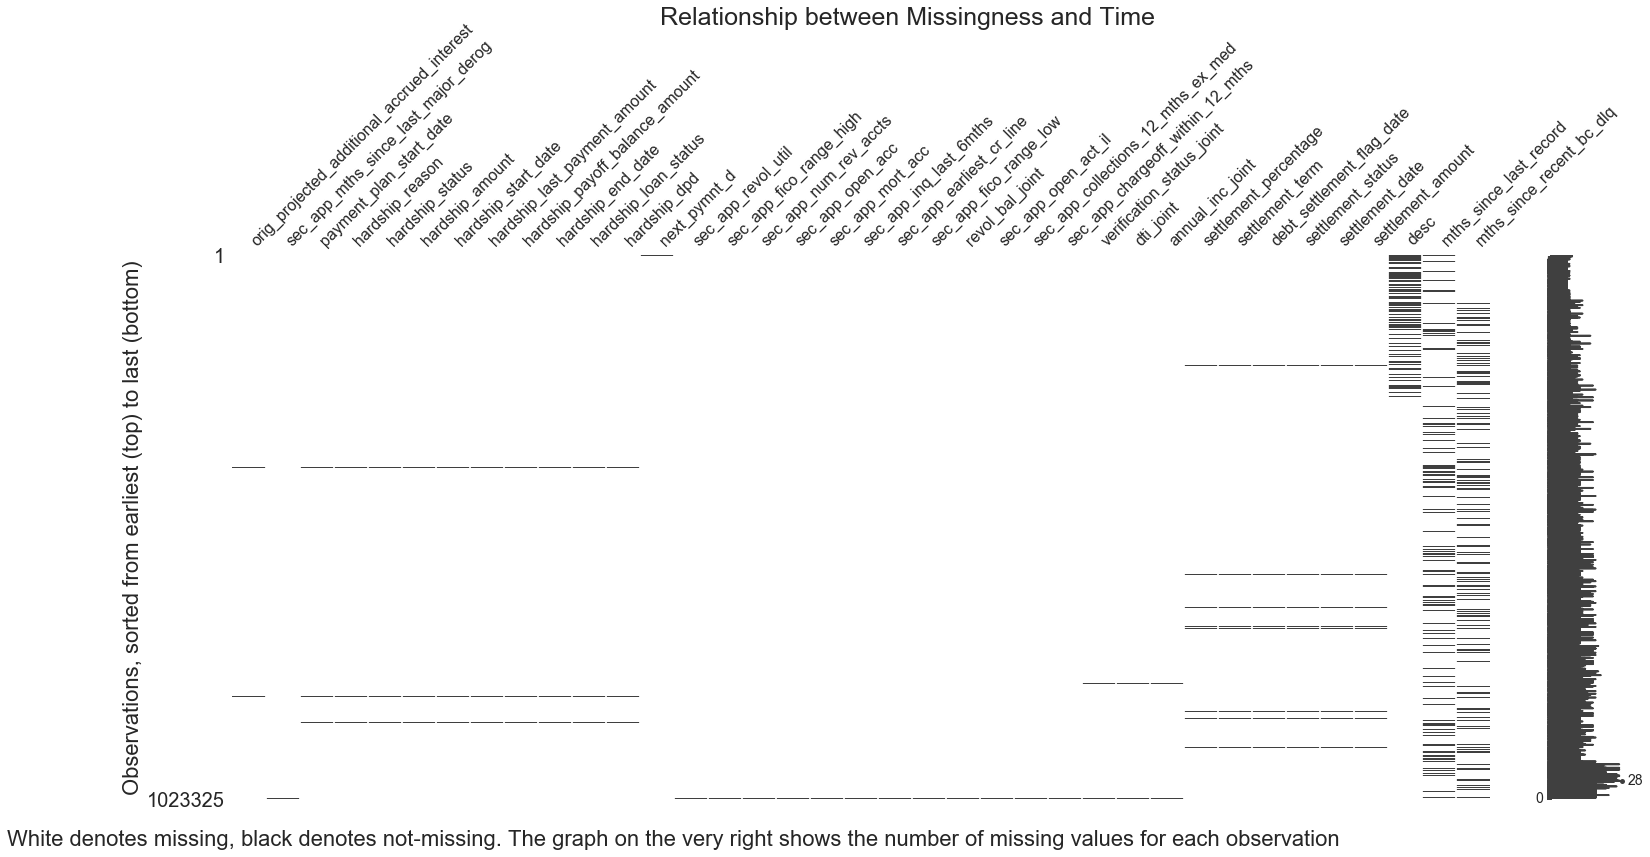

In [20]:
# Note that I don't explicitly exclude columns that have no missing values, because those will 
# automatically be discarded as irrelevant by missingno.
variables_to_plot_1 = missing[missing>.75].index # Select columns
missingno.matrix(all_data.loc[:, variables_to_plot_1])
plt.figtext(x=.5, y=1.2, s='Relationship between Missingness and Time', 
            fontsize=25, horizontalalignment='center')
plt.ylabel('Observations, sorted from earliest (top) to last (bottom)', fontsize = 22)
plt.figtext(x=0, y=.06, s='White denotes missing, black denotes not-missing. The graph on the very right '
            'shows the number of missing values for each observation', fontsize=22)
plt.show();

Most of these variables can safely be discarded since they were only collected for part of the sample period. The exceptions are the two rightmost variable, for which missingness is distributed relatively evenly across time. Thus, we will add them to a list of variables which to inspect later to make sure missingness doesn't actually stand for "not applicable".

In [21]:
# Create a list of variables to inspect later, and add the last two variables
variables_to_inspect = list(variables_to_plot_1[-2:])

# Create a list of variables to delete, and add all the plotted variables except the last two
variables_to_delete = list(variables_to_plot_1[:-2])
variables_delete = [variable for variable in variables_to_plot_1 if variable not in variables_to_inspect]

Now let's plot the remaining variables for which at least half of the values are missing. 

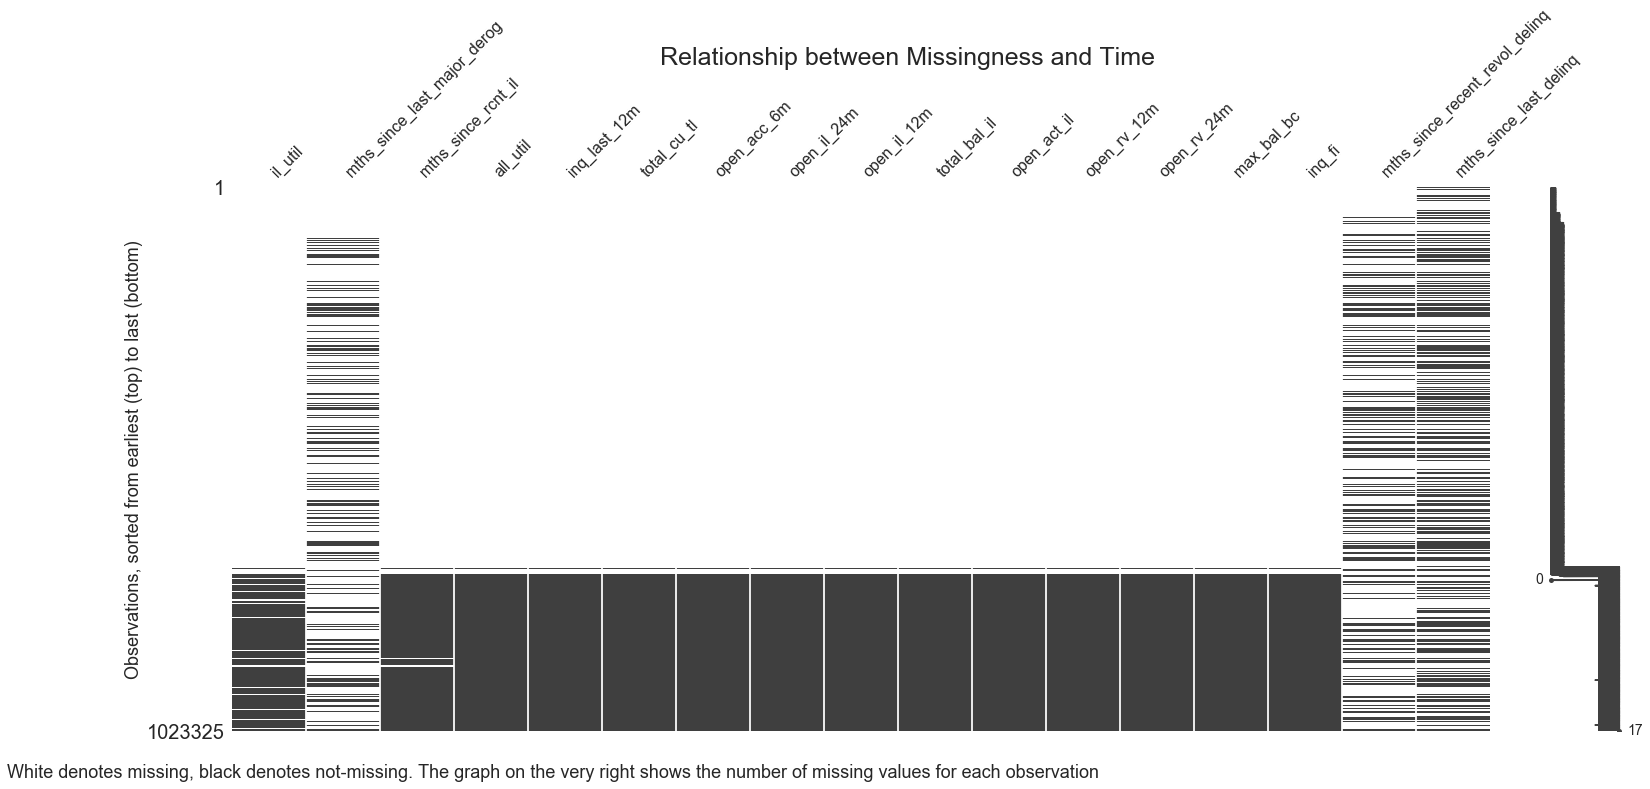

In [22]:
variables_to_plot_2 = missing[(missing <= .75) & (missing > .5)].index # Select columns
missingno.matrix(all_data.loc[:, variables_to_plot_2])
plt.ylabel('Observations, sorted from earliest (top) to last (bottom)', fontsize = 18)
plt.figtext(x=.5, y=1.05, s='Relationship between Missingness and Time', 
            fontsize=25, horizontalalignment='center')
plt.figtext(x=0, y=.06, s='White denotes missing, black denotes not-missing. The graph on the very right '
            'shows the number of missing values for each observation', fontsize=18)
plt.show();

Again, most of these variables were only collected for the last portion of the sample period, so we will discard them. However, for three variables missingness is distributed relatively evenly across time, so we will add them to the list of variables to inspect later.

In [23]:
# Add variables to list of variables to inspect later
variables_to_inspect.extend(['mths_since_last_major_derog', 'mths_since_recent_revol_delinq',
                            'mths_since_last_delinq'])

# Add variables to list of variables to delete
variables_to_delete.extend([v for v in variables_to_plot_2 if v not in variables_to_inspect])

Finally, let's plot missingness for variables that have less than 50% missing values. (We will ignore variables that have less than 0.5% missing values, because this is close enough to zero for our purposes to be ignored, and this reduces the number of variables sufficiently to fit them into one plot.)

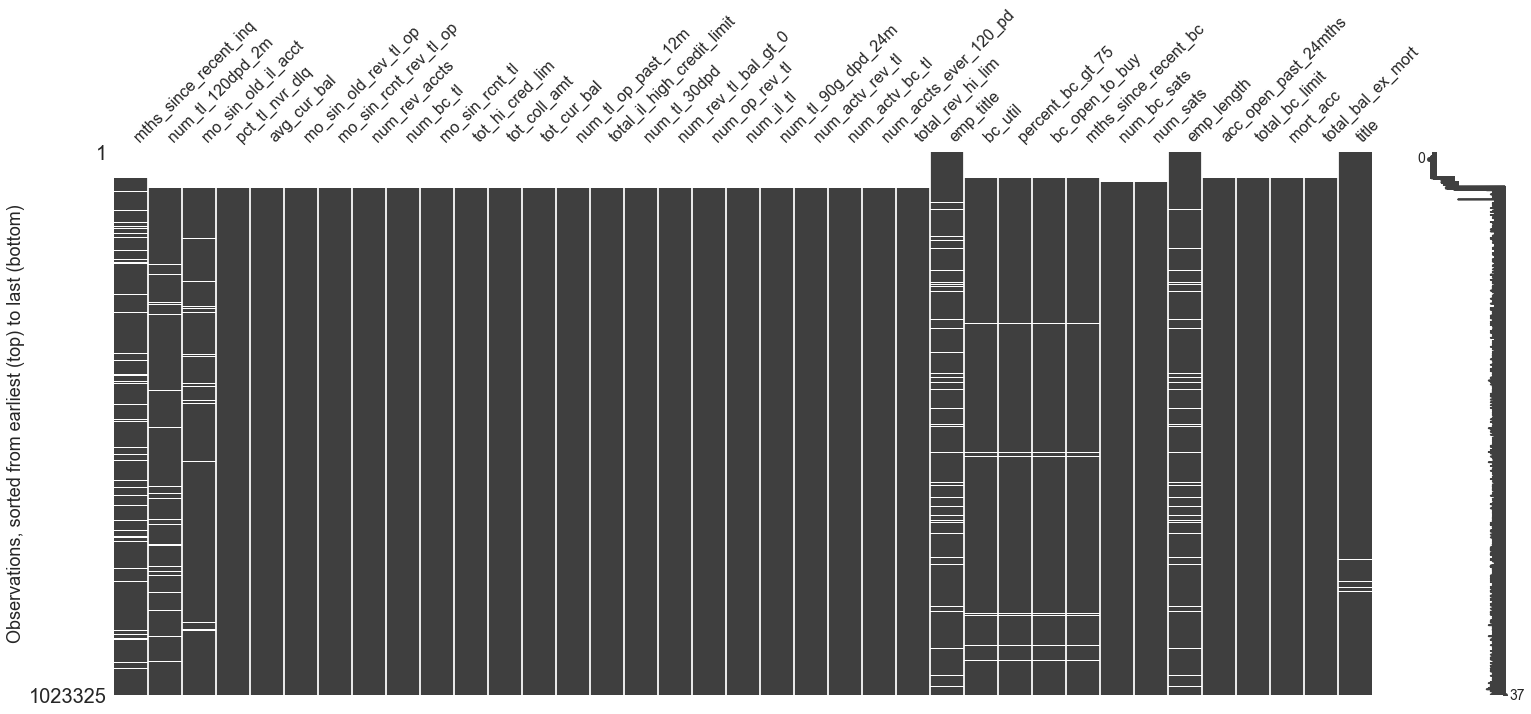

In [24]:
variables_to_plot_3 = missing[(missing < .50) & (missing > .005)].index # Select columns
missingno.matrix(all_data.loc[:, variables_to_plot_3])
plt.ylabel('Observations, sorted from earliest (top) to last (bottom)', fontsize = 18)
plt.show();

While for some of these variables were not collected at the very beginning of the sample periods, there is no need to drop them because their number of missing values (around 10%) is small enough to be imputed fairly reliably. (Furthermore, as we will see below, the earliest observations will be discarded from the sample anyway because Lending Club's business model was still in flux during its first years.)

Let us now inspect the variables we have singled out, to see whether missingness simply stands for "not applicable" instead of "value was not collected". Let's first print their names:

In [25]:
variables_to_inspect

['mths_since_last_record',
 'mths_since_recent_bc_dlq',
 'mths_since_last_major_derog',
 'mths_since_recent_revol_delinq',
 'mths_since_last_delinq']

All five variables refer to the number of months since a specific event which does not apply to all borrowers (e.g., experiencing a delinquency or a derogatory public record) happened. This explains why missingness for those variables is distributed relatively evenly across time: For those borrowers to which the particular event does not apply, the time since this event happened was encoded as missing. Unfortunately, there is no value in pandas that stands for "not applicable", so we will leave these values encoded as missing and decide on a better strategy once we know how exactly we are going to incorporate these variables into our model.

Since we decided not to drop any of these variables, our list of variables to drop is now complete, so let's go ahead and get rid of them:

In [26]:
# Drop variables with too many missing values
all_data = all_data.drop(variables_to_delete, axis=1)

#Print number of deleted variables
'{} variables were dropped'.format(len(variables_to_delete))

'49 variables were dropped'

### Dropping endogenous columns
It is also important that we drop columns that contain information that was not available at the time the loan was issued (e.g., whether the borrower experienced hardship during the payback period). Needless to say, failing to do so could give us an unfair edge if we included any of these variables in our model. (In the language of statistics, they are endogenous to our model since they are part of what we want to explain rather than part of what we can use for the explanation.) 

Unfortunately, the only way to identify those variables is to go through all variables by hand and consider their meaning. So let's print all column names:

In [27]:
list(all_data.columns)

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'loan_status',
 'url',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'application_type',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',

In [28]:
all_data.loc[all_data.funded_amnt != all_data.funded_amnt_inv,
             ['loan_amnt','funded_amnt','funded_amnt_inv','total_pymnt','total_pymnt_inv']] \
                .head()

loan_amnt  funded_amnt  funded_amnt_inv  total_pymnt  total_pymnt_inv
issue_d    id                                                                          
2007-06-01 70686     5000.0       5000.0              0.0  5619.762090             0.00
           71623     6500.0       6500.0              0.0  7373.904962             0.00
           72176     2525.0       2525.0            225.0  2904.498829           258.82
           72998     1000.0       1000.0              0.0  1155.600899             0.00
           73582     3500.0       3500.0            225.0  3719.431070           239.11

In [29]:
len(all_data.loc[all_data.funded_amnt != all_data.funded_amnt_inv,:])

100021

Looking up the meaning of the variables in the data dictionary reveals a number of variables were not known at the time the loan was issued: The most obvious ones relate to the amount and timing of the borrower's payments, and whether any late fees or even a debt settlement occurred. Those will all be deleted. 

Beyond those clear-cut cases, a few variables require more explanation: Firstly, we have information on the grade and sub-grade of the loan, which was calculated by a Lending Club.  I will discard these variables because I want to make my own prediction of a borrower's creditworthiness. 

The same is true of the interest rate, though things are slightly more complicated here: On the one hand, the interest rate borrowers receive is a summary of their other attributes that make them more or less likely to default, similar to the loan grade.  On the other hand, it also has an additional causal impact on their probability of default since it influences the monthly payments or the length of the payback period.  However, we can resolve this dilemma by directly including the monthly payment amount as well as the loan term as predictors. Since these are presumably the only channels through which the interest rate exerts a causal effect on the default rate, we can safely discard the interest rate. 

Note that it may make sense to keep the interest rate as well as the loan grade around for the rest of the EDA (e.g., to visualize the average default rate broken down by loan grade), so we will add them to a separate list of variables to be deleted later.

In [30]:
# Variables to delete now
endogenous = ['out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 
              'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 
              'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 
              'debt_settlement_flag']

# Variables to delete later (keep around for EDA)
endogenous_2 = ['int_rate', 'grade', 'sub_grade']

Going through the meaning of our variables also reveals a number of irrelevant variables that we can delete: Most obviously, the URL of the listing data  does not tell us anything useful. The same is true of initial listing status (whether loan was sold whole or fractional), since this was decided randomly.

Finally, in addition to the amount that the borrower applied for, we also have information on both the amount that was funded overall, and the amount that was funded through Lending Club's investors. While neither the data dictionary nor the website explains how this discrepancy is funded, this need not concern us. We will only keep the overall amount that was funded, and discard the amount that was funded through investors, as well as the amount that the borrower originally applied for. Even though a discrepancy between those variables may contain useful information, it is better not to include it as a predictor: Both Lending Club and its investors presumably made their decision to only partially fund a loan request based on the same information we have available, and we want to make our own prediction. Thus, we will add those variables to the list of irrelevant variables to be deleted.

In [31]:
irrelevant = ['url', 'initial_list_status', 'loan_amnt', 'funded_amnt_inv',]

Now let's go ahead and delete both the irrelevant and the endogenous variables (except those endogenous variables we decided to keep around for the rest of the EDA).

In [32]:
# Deleting variables
all_data = all_data.drop(endogenous + irrelevant, axis='columns')

## Making sure variables are of the right type 

Now let's inspect the data type for each column. We will start with all variables that are currently 

floats.  The main thing that can be wrong here is that they are actually integers. Note that this only matters if the variable doesn't have any missing values. (Since the integer type cannot represent missing values, we have to store them as floats anyway.) So let's find all variables that are both integers and don't have any missing values.

In [33]:
integers = [variable for variable in all_data.dtypes[all_data.dtypes==float].index
            if all_data.loc[:, variable].apply(float.is_integer).all()]
integers

['funded_amnt',
 'fico_range_low',
 'fico_range_high',
 'revol_bal',
 'last_fico_range_high',
 'last_fico_range_low',
 'good']

Let's convert those variables to integers, since these use less memory.

In [34]:
all_data[integers] = all_data.loc[:, integers].astype(int)

Now let's inspect the remaining variables, which are all of type "object". 

In [35]:
objects = all_data.dtypes[all_data.dtypes=='O'].index
all_data.loc[:, objects].head()

term int_rate grade sub_grade                   emp_title emp_length home_ownership  \
issue_d    id                                                                                                 
2007-06-01 70686   36 months    7.75%     A        A3                   Homemaker  10+ years       MORTGAGE   
           71623   36 months    8.38%     A        A5                         NaN   < 1 year           NONE   
           72176   36 months    9.33%     B        B3                         NaN   < 1 year           RENT   
           72998   36 months    9.64%     B        B4  Halping hands company inc.   < 1 year           RENT   
           73582   36 months   10.28%     C        C1                         NaN   < 1 year           RENT   

                 verification_status                                        loan_status purpose              title  \
issue_d    id                                                                                                        
2007-06-01 70686        Not Verified  Does not meet the credit policy. Status:Fully ...   other     Aroundthehouse   
           71623        Not Verified  Does not meet the credit policy. Status:Fully ...   other       Buying a car   
           72176        Not Verified  Does not meet the credit policy. Status:Fully ...   other    Car repair bill   
           72998        Not Verified  Does not meet the credit policy. Status:Fully ...   other            delight   
           73582        Not Verified  Does not meet the credit policy. Status:Fully ...   other  Wedding coming up   

                 zip_code addr_state earliest_cr_line revol_util last_credit_pull_d application_type  \
issue_d    id                                                                                          
2007-06-01 70686    068xx         CT              NaN        NaN           Feb-2015       Individual   
           71623    100xx         NY              NaN        NaN           Aug-2007       Individual   
           72176    100xx         NY              NaN        NaN           May-2007       Individual   
           72998    021xx         MA              NaN        NaN           Sep-2014       Individual   
           73582    100xx         NY              NaN        NaN           Feb-2013       Individual   

                 disbursement_method  
issue_d    id                         
2007-06-01 70686                Cash  
           71623                Cash  
           72176                Cash  
           72998                Cash  
           73582                Cash

Term, interest rate, and the revolving credit utilization rate can easily be converted to numeric by deleting the appended unit ("months", "%", and "%", respectively) from each value.

In [38]:
all_data['term'] = pd.to_numeric(all_data.term.str.replace(' months', ''))
for variable in ['int_rate', 'revol_util']:
    all_data[variable] = pd.to_numeric(all_data.loc[:, variable].str.replace('%', ''), errors='coerce')

The variables "earliest credit line" and "last credit pull date" are dates, so let's convert them to datetime objects.

In [ ]:
for variable in['earliest_cr_line', 'last_credit_pull_d']:
    all_data[variable] = pd.to_datetime(all_data.loc[:, variable], format='%b-%Y')

However, it is not these *absolute* dates that will be the best predictors; rather, what ultimately matters is how long ago – relative from the loan issue date – these events occurred. Thus, let's create a new features for this, and drop the absolute dates.

In [ ]:
# Create new variables with time difference
all_data['earliest_cr_line_days'] = (all_data.reset_index(level='issue_d').issue_d -
    all_data.reset_index(level='issue_d').earliest_cr_line).dt.days
all_data['last_credit_pull_days'] = (all_data.reset_index(level='issue_d').issue_d -
    all_data.reset_index(level='issue_d').last_credit_pull_d).dt.days

# Delete absolute dates
all_data = all_data.drop(['earliest_cr_line', 'last_credit_pull_d'], axis='columns')

The remaining variables are categorical. Before fitting our models, we will need to perform one-hot-encoding on them.  However, for the EDA it is more convenient to leave them as objects.

While we're at it, let's save the name of those variables for later.

In [ ]:
categorical = ['grade', 'sub_grade', 'emp_length', '_ownership', 'verification_status', 'loan_status', 'zip_code', 'addr_state', 'application_type', 'disbursement_method' ]

Finally, let's have a look at all our numeric variables to make sure they are not actually ordinal or categorical. The reason we care about this is that we not only have to use different descriptive statistics and visualization techniques during the EDA, but we also need to transform them using one-hot-encoding before using them as predict yours in our machine learning models. The only exception is if the variable only takes on two unique values.

In [52]:
with pd.option_context('display.max_rows', 100):
    print(all_data.dtypes[all_data.dtypes!=object])

funded_amnt                         int32
int_rate                          float64
installment                       float64
annual_inc                        float64
dti                               float64
delinq_2yrs                       float64
fico_range_low                      int32
fico_range_high                     int32
inq_last_6mths                    float64
mths_since_last_delinq            float64
mths_since_last_record            float64
open_acc                          float64
pub_rec                           float64
revol_bal                           int32
revol_util                        float64
total_acc                         float64
last_fico_range_high                int32
last_fico_range_low                 int32
collections_12_mths_ex_med        float64
mths_since_last_major_derog       float64
acc_now_delinq                    float64
tot_coll_amt                      float64
tot_cur_bal                       float64
total_rev_hi_lim                  

The only variable that is not actually numeric is our target variable, whether the borrower defaulted. However, since it only takes on two unique values, 0 or 1, this is indeed how we want to encode it.

## Univariate Distributions

Let's now inspect the (univariate) distribution for each variable with a boxplot. We will start with numeric variables. Two questions are of main interest here: Firstly, we want to examine if the distribution is skewed. If this is the case, it is usually best to apply a transformation to reduce this skew. Secondly, are there any outliers? Oftentimes, outliers are the result of a skewed distribution, and thus the same transformation that reduces skew frequently also makes outliers less severe. However, if this is not enough, we should take a closer look at the particular observation to determine if it looks like a measurement or data entry error has occurred. In this case, we may drop the offending observations.

A good way to examine skew and look for outliers is to graph the distribution for each variable with a boxplot.
(The exception are variables with only a small number (Less than 10) of unique observations, we will plot these with a histogram.) 

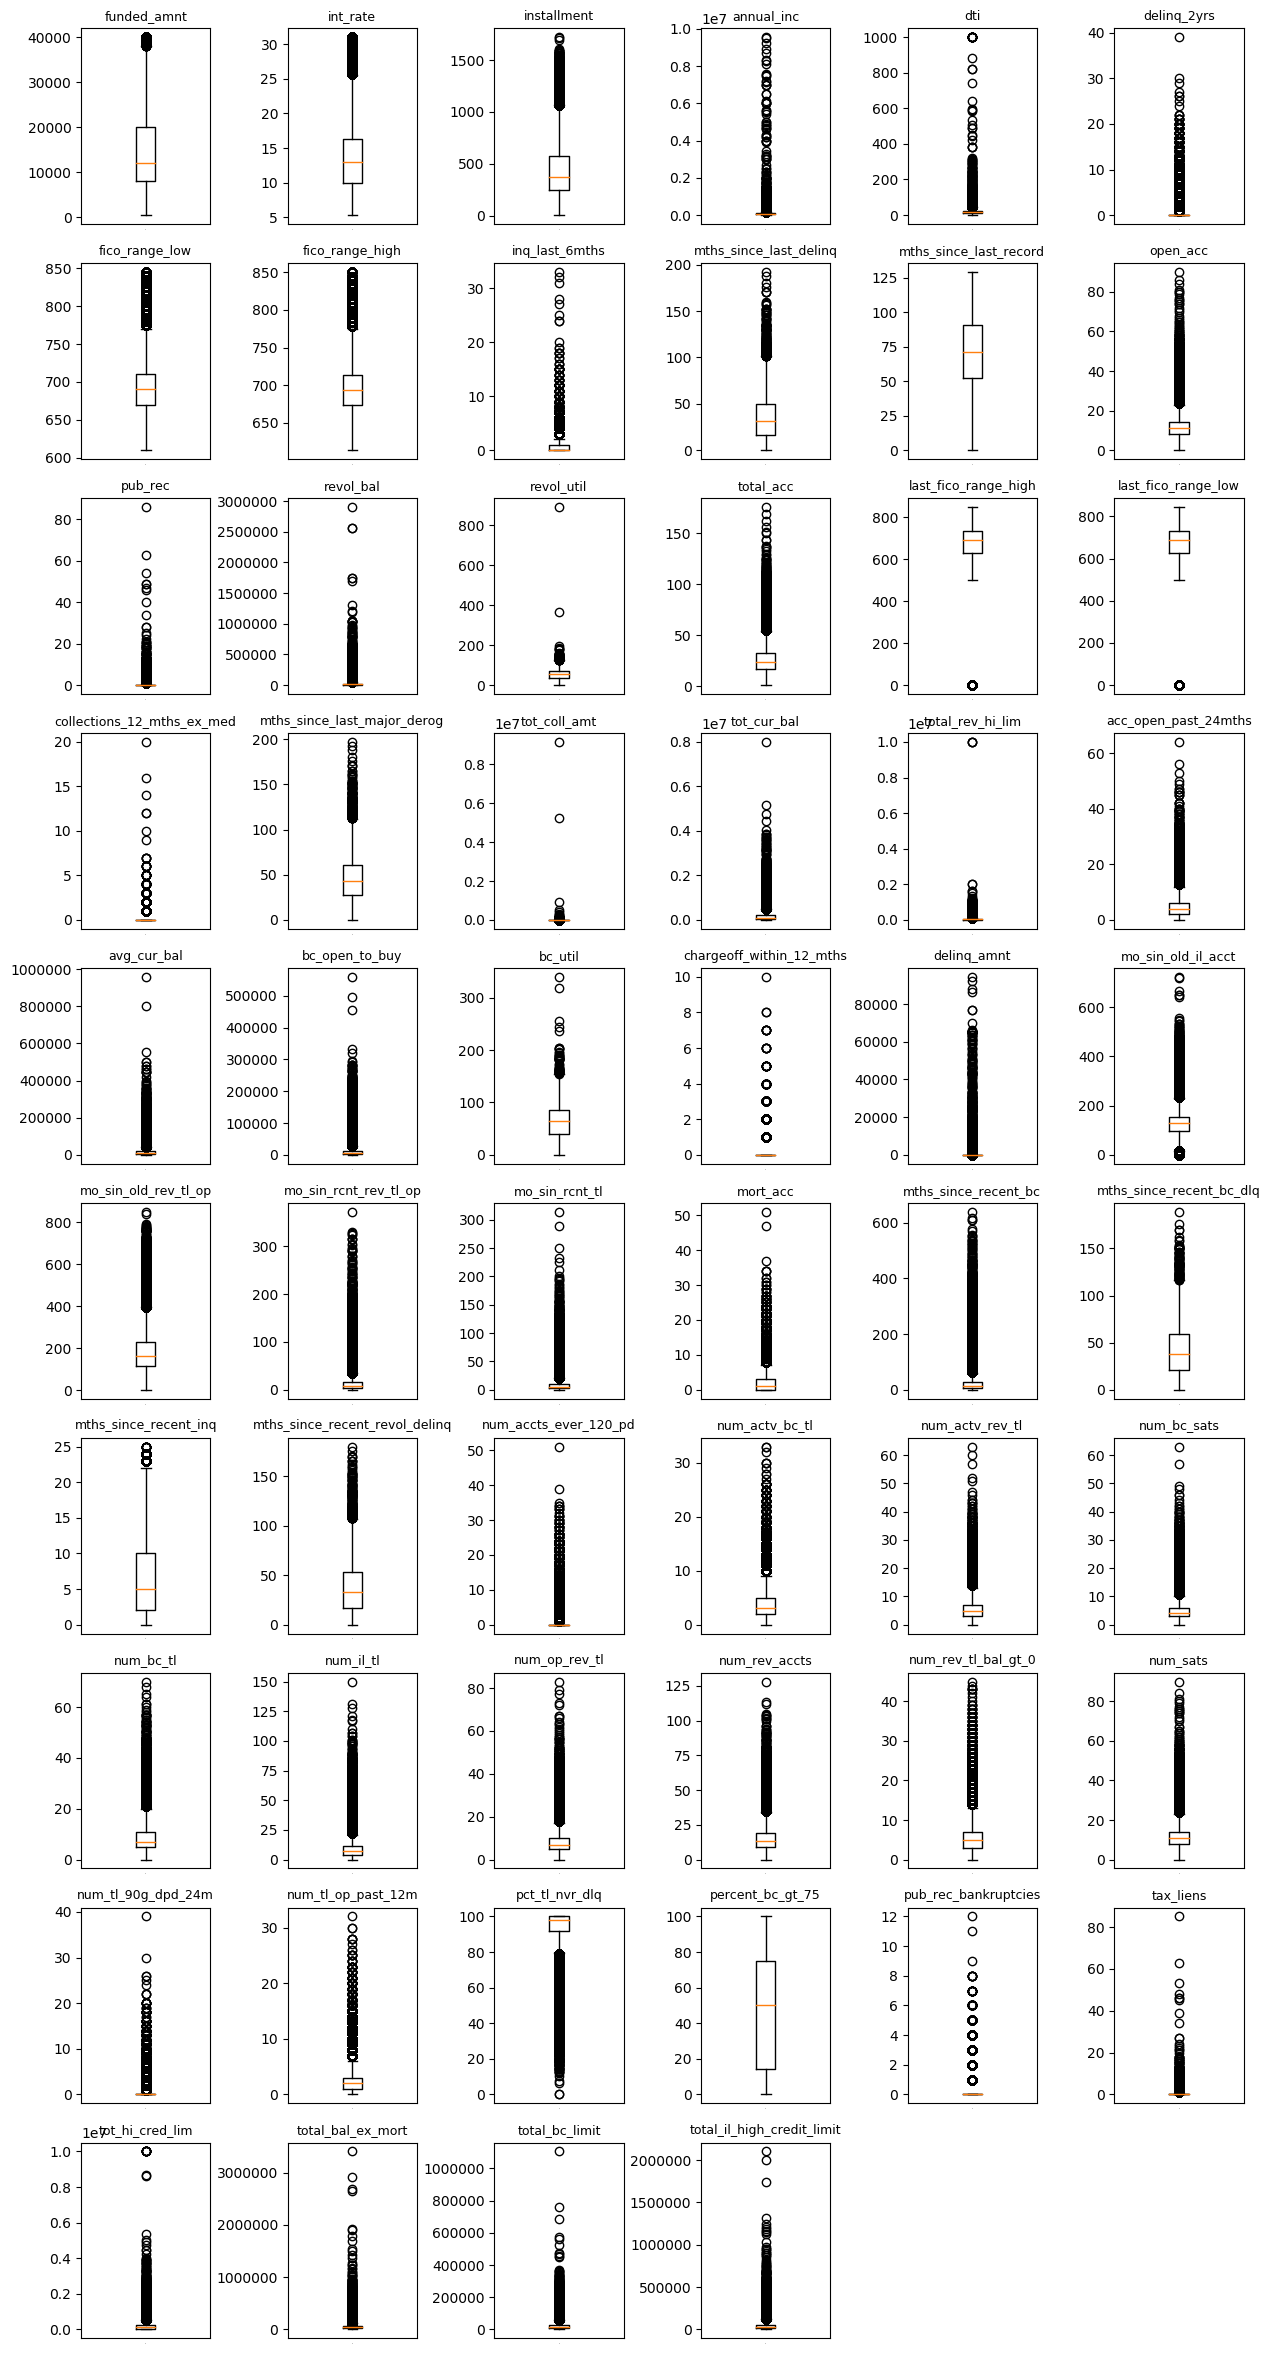

In [92]:
# get names of all the numeric variables
numerics = all_data.dtypes[all_data.dtypes!=object].index
# Count the number of unique values for each numeric variable
n_unique = all_data.loc[:, numerics].nunique()
# Add variables with more than 10 unique values to a list of variables to
# plot with a boxplot, otherwise to list for histogram
numerics_box = n_unique[n_unique >= 10].index
numerics_hist = n_unique[n_unique < 10].index  

# Make a boxplot for each
sns.reset_defaults()
fig, ax = plt.subplots(nrows=10, ncols=6, figsize=(15,30))
for subplot, variable in zip(ax.ravel(), numerics_box):
    subplot.boxplot(all_data.loc[all_data[variable].notnull(), variable])
    subplot.set_title(variable, fontsize=9)
    #Remove x-axis labels
    subplot.tick_params(axis='x', labelsize=0, length=0) 

# Delete the last subplots that we didn't need 
# (starting with the 5th in the last row)
for column_index in range(4, 6):
    ax[-1, column_index].axis('off')

# Increase spacing between plots    
fig.subplots_adjust(hspace=.2, wspace=.6)
 
plt.show()

Due to the large number of variables, we will not spend too much time looking at each single plot but rather just try to get a feel for the big picture and look for anomalies. The first thing that stands out is that most of our variables are right-skewed (have fat tails on the right). This is best addressed with a log-transformation. (All variables are positive, and while some contain zeros, we can simply add 1 to them before taking the log.) Thus, I create a function that tests for each variable if a log-transformation would reduce the skew, and if so, it applies this transformation and moves the original variable to a new data frame in case we need it later.

Before we do that, however, we need to address one anomaly: It seems to be an in the *last* FICO range: For both its high and low, there are zeros, which is impossible since the score only ranges from 300-850. We will set these values as missing. But first let'scount the percentage of zeros to make sure we don't introduce too many missing values.

In [114]:
print(round((all_data.last_fico_range_low<300).mean(), 4))
print(round((all_data.last_fico_range_high<300).mean(), 4))

0.0255
0.0002


It doesn't introduce more than 3% of additional missing values, so we can go ahead and set these zeros as missing.

In [119]:
for v in ['last_fico_range_high', 'last_fico_range_low']:
    all_data.loc[all_data[v]==0, v] = np.nan

Now we are ready to apply the log transformation aware it reduces the skew. To measure skew, I assess how close the median is located from the midpoint between the 25th and  75th percentile.  Since it does not rely on the mean, this measure is more robust to outliers than the third central moment ("skewness").

In [131]:
all_data.quantile(q=[.25, .5, .75])

,funded_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,good
0.25,8000.0,9.99,249.96,45374.0,11.72,0.0,670.0,674.0,0.0,16.0,52.0,8.0,0.0,5982.0,34.4,17.0,629.0,635.0,0.0,27.0,0.0,0.0,29602.0,13900.0,2.0,3111.0,1368.0,39.8,0.0,0.0,98.0,117.0,4.0,3.0,0.0,6.0,21.0,2.0,17.0,0.0,2.0,3.0,3.0,5.0,4.0,5.0,9.0,3.0,8.0,0.0,0.0,0.0,1.0,91.7,14.3,0.0,0.0,49242.0,20899.0,7600.0,14500.0,1.0
0.50,12000.0,12.99,375.54,65000.0,17.48,0.0,690.0,694.0,0.0,31.0,71.0,11.0,0.0,11159.0,53.1,24.0,694.0,690.0,0.0,43.0,0.0,0.0,80816.0,23700.0,4.0,7449.0,4424.0,64.5,0.0,0.0,129.0,164.0,8.0,5.0,1.0,13.0,38.0,5.0,33.0,0.0,3.0,5.0,4.0,7.0,7.0,7.0,13.0,5.0,11.0,0.0,0.0,0.0,2.0,97.9,50.0,0.0,0.0,112104.0,37092.0,14700.0,31266.0,1.0
0.75,20000.0,16.24,577.33,90000.0,23.82,0.0,710.0,714.0,1.0,50.0,91.0,14.0,0.0,19741.0,71.4,32.0,734.0,730.0,0.0,61.0,0.0,0.0,210188.0,39800.0,6.0,18724.0,11720.0,85.5,0.0,0.0,152.0,229.0,16.0,10.0,3.0,28.0,59.0,10.0,53.0,0.0,5.0,7.0,6.0,11.0,11.0,10.0,19.0,7.0,14.0,0.0,0.0,0.0,3.0,100.0,75.0,0.0,0.0,250345.0,61923.5,27500.0,55829.0,1.0


In [135]:
def skew(df):
    """Returns the skew of each variable in a DataFrame, measured as the relative deviation
    of the median from the midpoint of the 25th and 75th percentile.
    """

    quartiles = df.quantile(q=[.25, .5, .75])
    
    return(quartiles.apply(lambda x: (x[.75] - x[.5])/(x[.5] - x[.25] )))

skew(all_data.loc[:, numerics])

C:\Users\t\Miniconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\t\Miniconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


funded_amnt                       2.000000
int_rate                          1.083333
installment                       1.606864
annual_inc                        1.273820
dti                               1.100694
delinq_2yrs                            NaN
fico_range_low                    1.000000
fico_range_high                   1.000000
inq_last_6mths                         inf
mths_since_last_delinq            1.266667
mths_since_last_record            1.052632
open_acc                          1.000000
pub_rec                                NaN
revol_bal                         1.657717
revol_util                        0.978610
total_acc                         1.142857
last_fico_range_high              0.615385
last_fico_range_low               0.727273
collections_12_mths_ex_med             NaN
mths_since_last_major_derog       1.125000
acc_now_delinq                         NaN
tot_coll_amt                           NaN
tot_cur_bal                       2.526106
total_rev_h

In [68]:

def transform_features(df):
    """… 
    TODO: Consider warning the user if there are (E.g.) less than than 10 unique
          values and suggest considering to treat the variable as categorical.
    """
    # Get names of all the numeric features
    numerics = df.dtypes[(df.dtypes==int) | (df.dtypes==float)].index.tolist()
    
    # Count the number of unique values for each numeric variable
    n_unique = all_data.loc[:, numerics].nunique()
    # Save variables (including counts) to examine
    examine = n_unique.loc[n_unique < 10]      
    # Variable names to potentially transform
    transform_candidates = n_unique.loc[n_unique >= 10].index  
    
    # Loop over all the variables and determine whether log decreases skew
    transform = []
    for v in transform_candidate:
    
    # inspect each selected variable in turn
    print()
transform_features(all_data)

Index(['funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low',
       'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
       'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_90g_dpd_24m', 'num_tl_op_pa

The following might have too many categories, so let's examine them into more detail:

In [ ]:
for variable in ['emp_title', 'purpose', 'title']:
        print(variable, ':\n',
              all_data.loc[:, variable].value_counts().sort_values(ascending=False).head(20),
              '\n')

Delete title, keep purpose.  They both refer to what the loan is used for, but purpose is selected from a set of given categories, while title is filled in by the borrower.  Therefore, while title can have more details when the loan doesn't fit into any of the given categories, it would have to do natural language processing to extract the meaning.  Since this is beyond the scope of this analysis, we will only use purpose.

## Multivariate Distributions

## Get rid of variables marked for deletion

In [43]:
# all_data = all_data.drop(endogenous_2, axis='columns')

funded_amnt        term  installment                                       emp_title emp_length  \
issue_d    id                                                                                                           
2007-06-01 70686             5000   36 months       156.11                                       Homemaker  10+ years   
           71623             6500   36 months       204.84                                             NaN   < 1 year   
           72176             2525   36 months        80.69                                             NaN   < 1 year   
           72998             1000   36 months        32.11                      Halping hands company inc.   < 1 year   
           73582             3500   36 months       113.39                                             NaN   < 1 year   
           74014             6450   36 months       211.85                                  Apto Solutions    2 years   
           74323             6500   36 months       208.66                                       Air Force   < 1 year   
           74505             2000   36 months        64.50                                             NaN   < 1 year   
           76629             1275   36 months        42.65                            Infinitely law group     1 year   
           77757             3000   36 months        95.86                                             NaN   < 1 year   
           77792             3000   36 months        95.42                                    Tanks Tavern   < 1 year   
           81085            10500   36 months       344.87                              Town of Plainville    3 years   
           83185             1000   36 months        30.94                                   Mana Products    6 years   
           83489             2600   36 months        81.94                            College Pro Painters    3 years   
           83979             3000   36 months        93.23                                              NC     1 year   
           84098             2500   36 months        77.69                                       U.S. Bank    9 years   
           84670             5000   36 months       156.11   Diamond Management and Technology Consultants  10+ years   
           85675             1000   36 months        34.21                                          Macy's  10+ years   
           85781             1400   36 months        45.78   Stanford University Libraries, LOCKSS Project   < 1 year   
           85818             5000   36 months       164.23                          Compensation Solutions   < 1 year   
           85961             1200   36 months        38.17                              Classic Components   < 1 year   
           87023             7500   36 months       255.43                                Evergreen Center   < 1 year   
           88046             4400   36 months       141.25               Brick Township board of education    2 years   
           88637             6000   36 months       195.28                                 Yale University   < 1 year   
2007-07-01 100134            1000   36 months        33.45                            Portrait Innovations     1 year   
           101579           10000   36 months       323.98                            RoadNarrows Robotics   < 1 year   
           102376           25000   36 months       813.65  Institute for Mind/Body Research and Education    2 years   
           102823            4500   36 months       150.52                                  McCamey Family     1 year   
           103478            1800   36 months        61.86                 North Carolina State University     1 year   
           103507            4000   36 months       139.31                                   Ernst & Young    3 years   
...                           ...         ...          ...                                             ...        ...   
2018-03-01 130894578        3

# Predictive modeling
We will model loan default as dichotomous, either yes or no. While it is generally best to model a phenomenon at the most fine-ingrained measurement scale possible in order to minimize a model's variance, we unfortunately do not have all the required information to model default as the return on investment. Doing so would be advantageous, because it would take into account that earlier default is worse than later default. Thus, if the different features vary in terms of *when* the default that they can predict is likely to occur, modeling the ROI would allow us to make more accurate decisions whether a specific customer is profitable.

Unfortunately, though, we don't have all the information to calculate the *time* value of payments received: Even though we do have the total amount of payments from each borrower, we don't know at what times these were received.  (Though we could try to impute these based on a number of pieces of information we do have available, the additional error introduced by this imputation is likely to outweigh any gains made from modeling default as a continuous event.) Therefore, I will model default as a dichotomous variable.

Perform one-hot-encoding of categorical variables. Go through a list of all numerical variables to make sure they are not supposed to be categorical.